In [ ]:
import numpy as np
import pandas as pd
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path, calculate_rmse, plot_rmse_per_epoch, generate_data, compare_tickers_scatter
from qiskit.providers.fake_provider import GenericBackendV2
from sklearn.metrics import mean_squared_error

## Load the model

In [2]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
print(latest_model_path)

models/models_0110.1410


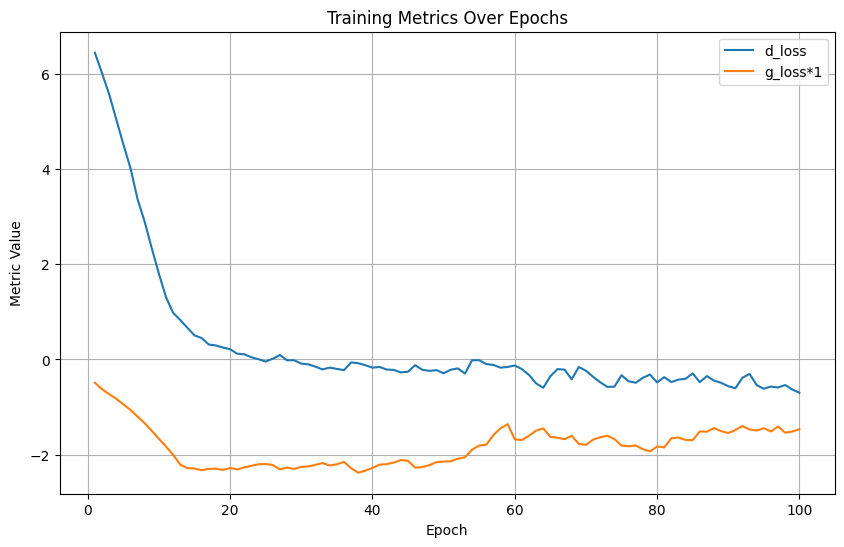

In [3]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1)

In [4]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

## Load data

In [5]:
# Load data
feature_data, target_data = process_model_data(targets, features, tickers)

c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust

(1003, 32) (1003, 8)


## Load the Qiskit circuit

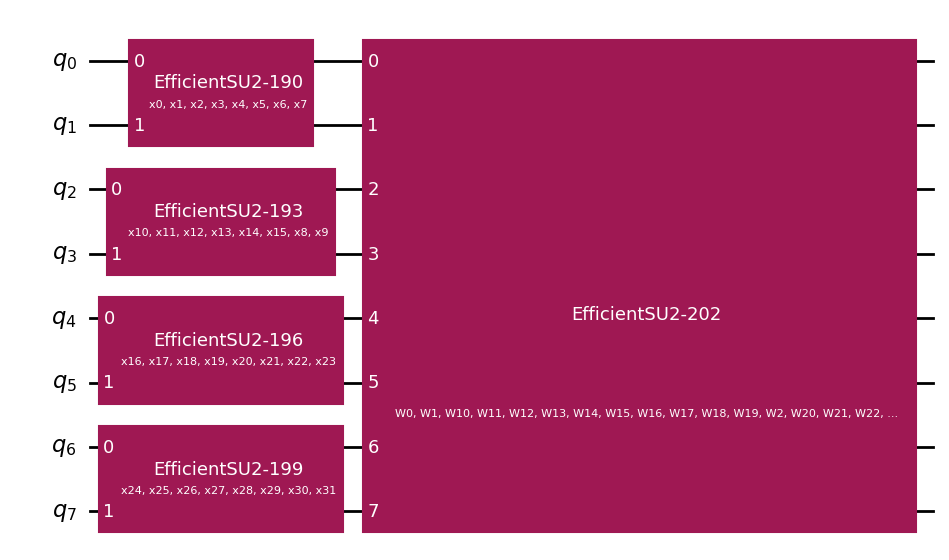

In [7]:
# Load circuit
qc= two_qubit_circuit_tickers(tickers)
qc.draw('mpl')

In [8]:
# Load weights
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [12]:
# Generate Data
# data is randomly sampled so returns the generated data along with the associated real data (if samplig=True)

backend = GenericBackendV2(num_qubits=qc.num_qubits)

outputs, target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 100,
)

Processing inputs: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


## Finding the Root Mean Squared Errors
This is a better accuracy metric for us as the generator/discriminator loss doesn't tell us much

An RMSE of 0.10 means we are off by 10%

In [25]:
# Calculate RMSE for each ticker and output feature
rmse_dict = calculate_rmse(
    generated_data= outputs,
    target_data= target_outputs, 
    ticker_labels= tickers,
    target_labels = targets
)

for k, v in rmse_dict.items():
        print(f"{k}: {v:.4f}")

avg_rmse = mean_squared_error(target_outputs, outputs)
print(f"Average RMSE: {avg_rmse}")

GOOG_OC_next: 0.6435
GOOG_CO_next: 0.4747
AAPL_OC_next: 0.9880
AAPL_CO_next: 0.7250
MSFT_OC_next: 0.8432
MSFT_CO_next: 0.9623
AMZN_OC_next: 0.5897
AMZN_CO_next: 0.3733
Average RMSE: 0.533164260676976


Processing inputs: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


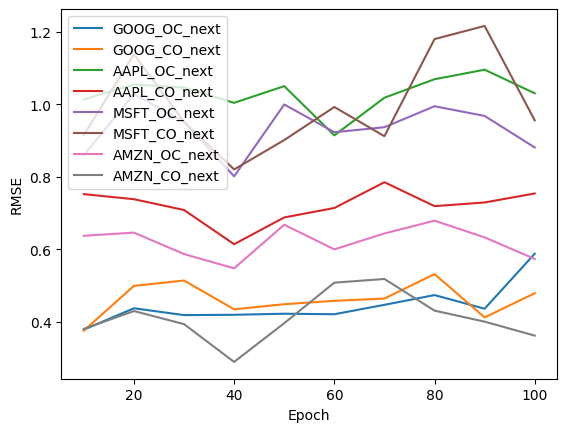

{'GOOG_OC_next': [np.float64(0.3790697958608836),
  np.float64(0.4380746659785632),
  np.float64(0.4192061436187486),
  np.float64(0.4201175206936561),
  np.float64(0.423015833624038),
  np.float64(0.42159087762464015),
  np.float64(0.4475218715156578),
  np.float64(0.4744122962835173),
  np.float64(0.43681493540904737),
  np.float64(0.5884185887709008)],
 'GOOG_CO_next': [np.float64(0.3763186720520414),
  np.float64(0.4997262115135388),
  np.float64(0.5145205993619749),
  np.float64(0.43515657047284434),
  np.float64(0.44920166095625375),
  np.float64(0.45859710727457376),
  np.float64(0.46480117234896956),
  np.float64(0.5323008280878553),
  np.float64(0.41284037661387835),
  np.float64(0.4794632295103726)],
 'AAPL_OC_next': [np.float64(1.013685646241064),
  np.float64(1.054485032337462),
  np.float64(1.0464391936038582),
  np.float64(1.0041693390415556),
  np.float64(1.0501630164018232),
  np.float64(0.9144599674052145),
  np.float64(1.018270430257542),
  np.float64(1.06923631421577

In [ ]:
# Plot the RMSE per epoch
rmse_per_epoch=plot_rmse_per_epoch(model_path=latest_model_path,
                    qc=qc, 
                    feature_data=feature_data, 
                    target_data=target_data, 
                    target_labels=targets, 
                    ticker_labels=tickers, 
                    sample_size = 100,
                    every_n_epochs=10,
)

## Comparing to random weights

In [27]:
random_weights = np.random.randn(len(loaded_weights))

random_outputs, random_target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 500,
)
random_rmse = mean_squared_error(random_target_outputs, random_outputs)
print(f"Average RMSE for random weights: {random_rmse}")
print(f"Average RMSE for trained weights: {avg_rmse}")

Processing inputs: 100%|██████████| 500/500 [02:20<00:00,  3.56it/s]

Average RMSE for random weights: 0.5626903416364802
Average RMSE for trained weights: 0.533164260676976


## Plotting the ticker comparison distributions

In [ ]:
# Turning the results into a df
columns = [f"{ticker}_{target}" for ticker in tickers for target in targets]

df_gen = pd.DataFrame(outputs, columns=columns)
df_real = pd.DataFrame(target_outputs, columns=columns)


In [46]:
df_gen.head()

,GOOG_OC_next,GOOG_CO_next,AAPL_OC_next,AAPL_CO_next,MSFT_OC_next,MSFT_CO_next,AMZN_OC_next,AMZN_CO_next
0,0.437500,-0.131348,-0.238281,0.008789,0.031738,0.533691,0.378418,0.038086
1,0.224609,-0.181152,-0.036133,0.333984,0.033203,-0.314941,0.057129,0.373047
2,0.078613,0.114258,-0.012207,-0.093750,0.035156,-0.050293,0.020020,0.313965
3,0.122559,0.038086,0.164551,-0.166992,-0.062012,-0.224121,-0.018555,-0.106934
4,0.208984,0.331055,0.097656,-0.489258,0.030762,-0.306152,-0.017090,-0.215332


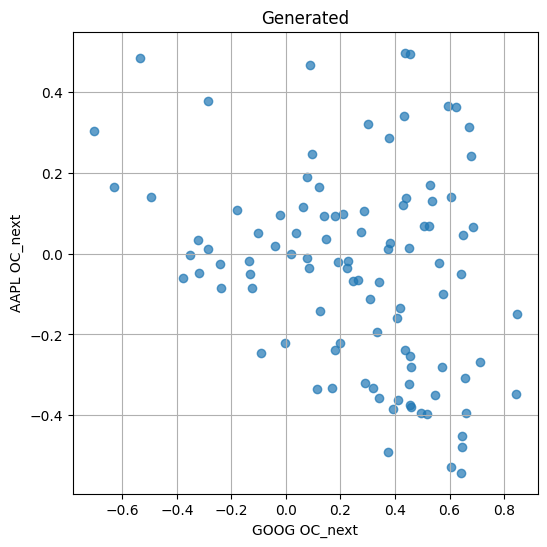

In [48]:
compare_tickers_scatter(df_gen, "GOOG", "AAPL", title= "Generated", feature="OC_next")

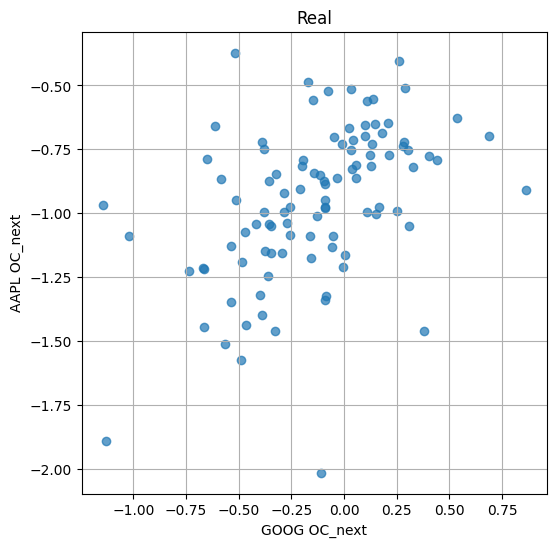

In [49]:
compare_tickers_scatter(df_real, "GOOG", "AAPL",title= "Real", feature="OC_next")